In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

## Load all datasets from Kaggle

In [4]:
all_teams = pd.read_csv('teams.csv')
seasons= pd.read_csv('Seasons.csv')
reg_compact = pd.read_csv('RegularSeasonCompactResults.csv')
reg_detail = pd.read_csv('RegularSeasonDetailedResults.csv')
tour_compact = pd.read_csv('TourneyCompactResults.csv')
tour_detail = pd.read_csv('TourneyDetailedResults.csv')
tour_seeds = pd.read_csv('TourneySeeds.csv')
tour_slots = pd.read_csv('TourneySlots.csv')
sample_submission = pd.read_csv('SampleSubmission.csv')

## EDA - Creating a usable dataset

The relevant datasets provided by Kaggle have one row for each game played. The goal is to predict the outcome of games that have not been yet played (or at least games that have not been used to fit the model).  Data regarding an individual game cannot be used to predict the outcome of that game, because the data and outcome are simultaneously available.  Data available to predict a games outcome must be available prior to the game.  So I will use feature engineering to create a new set of (hopefully) useful factors.  These will be team level factors for tournament team for each season. I also include the seeding of teams in the tournament.  Initially, I will create a dataset that has one row for each team for each year.  Ultimately, I will create a dataset that has the actual matchups played a year or years of the tournament along with data regarding each of the two teams.  I will use this team level data for each of two teams to predict the outcome of a game between the two teams. 

The raw datasets are not directly factors in the model, so the only EDA was looking at the contents of each dataset.  Visual and other EDA will be more important once I have engineered usable features. 

## Feature Engineering

I created a set of functions that I can use to engineer team level data for each season. For each season I use data
from the regular season to create factors.  The tournament data is the data that I use for fitting and testing my models. I used only data from the compact data sets, becaue this data is available for many additional years. 

##### Assumption: I am assuming that the additional information available in the detailed datasets is not as important as the additional years available in the compact datasets. 

One team level factor that is provided directly by Kaggle is a tournament seed for each team participating in a tournament.  In order to use the seeding I have defined a function that can list the seeding in a useable format for me to engineer team level data.

#### Define Function that takes team and season information and returns an integer for the team/season.

In [6]:
def get_seed(year, team):
    df_seeds = tour_seeds[tour_seeds.Season == year]
    
    try: 
        seed = df_seeds[df_seeds.Team == int(team)]['Seed'].values[0]
        return int(seed[1:3])
    
    except:
        return None  ## returns none if team is not invited to tournament for year given

##### Assumption: I am assuming that tournament results can be best predicted by using data from games played during the same season.  I am making the assumption on the basis that the high turnover of players renders data from previous seasons significantly less important than same season data.  If I was predicting the results of profession sports -- I would not make this assumption.

Define function that takes a year and returns a dataframe containing average margin of victory/loss for each team and its opponents along with the seed(if any) for the team in that season's tournament.

In [7]:
def make_factors(year): ## this function returns information for non-tournament teams, because such information
                        ## is used to calculate the opponent margin of victory/loss used for tournament teams.
    
    def difficulty(factors):  ## average margin of victory/loss for opponents during regular season
        strength_dic = dict(zip(factors.Team.values, factors.Diff.values))
        difficulty_schedule = []
        for team in factors['Team']:
            opponents = []
            for i in results.index:
                if results.loc[i, 'Wteam'] == team:
                    opponents.append(results.loc[i, 'Lteam'])
                elif results.loc[i, 'Lteam'] == team:
                    opponents.append(results.loc[i, 'Wteam'])
            opp_strength = 0
            for opponent in opponents:
                opp_strength += strength_dic[opponent]/len(opponents)
            difficulty_schedule.append(opp_strength)
        return difficulty_schedule
    
    team_list = [team for team in all_teams.iloc[:, 0]]
    dif_list = []
    results = reg_compact[reg_compact['Season'] == year]
    team_year_list = team_list.copy()
    for team in team_list:
        point_dif = 0
        games_played = 0
        for i in results.index:
            if results.loc[i, 'Wteam'] == team:
                point_dif = point_dif + results.loc[i, 'Wscore'] - results.loc[i, 'Lscore']
                games_played += 1
            elif results.loc[i, 'Lteam'] == team:
                point_dif = point_dif + results.loc[i, 'Lscore'] - results.loc[i, 'Wscore']
                games_played += 1
        if games_played == 0:
            team_year_list.remove(team)
        else:
            dif_list.append(point_dif/games_played)
    
    factors = pd.DataFrame(index=None)
    factors['Team'] = [team for team in team_year_list]
    factors['Diff'] = [diff for diff in dif_list]
    factors['schedule_str'] = [strength for strength in difficulty(factors)]
    factors['Seed'] = [get_seed(year, team) for team in team_year_list]
    tour_factors = factors[factors.Seed.notnull()]
    tour_factors['Seed'] = [int(seed) for seed in tour_factors.Seed.values]
    return tour_factors

### Define a function that provides the data for the target. 

In [8]:
def results_makelist(year):  ## this list is used to create the target for modelling.
    resultlist = []
    results = tour_compact[tour_compact['Season'] == year]
    for index, row in results.iterrows():
        resultlist.append(str(row['Season']) + '_' + str(row['Wteam']) + '_' + str(row['Lteam']))
    return resultlist  

### Define a function to create a dataframe of data for modelling.

In [9]:
##takes a year and returns a dataframe with game results and team-level info

def make_dataset(year):  
    results = results_makelist(year)
    factors = make_factors(year)
    end = len(results)
    mid = int(end/2)
    wteams = [result[5:9] for result in results]
    lteams = [result[10:14] for result in results]
    wdiffs = [factors[factors.loc[:, 'Team'] == int(team)]['Diff'].values[0] for team in wteams]
    wsOs = [factors[factors.loc[:, 'Team'] == int(team)]['schedule_str'].values[0] for team in wteams]
    ldiffs = [factors[factors.loc[:, 'Team'] == int(team)]['Diff'].values[0] for team in lteams]
    lsOs = [factors[factors.loc[:, 'Team'] == int(team)]['schedule_str'].values[0] for team in lteams]
    draft = pd.DataFrame()
    draft['team1'] = wteams[0:mid] + lteams[mid:end] ### these lines provide that the target is about half of each
    draft['team2'] = lteams[0:mid] + wteams[mid:end] ### category
    draft['diffs1'] = wdiffs[0:mid] + ldiffs[mid:end]
    draft['diffs2'] = ldiffs[0:mid] + wdiffs[mid:end]
    draft['sOs1'] = wdiffs[0:mid] + ldiffs[mid:end]
    draft['sOs2'] = lsOs[0:mid] + wsOs[mid:end]
    draft['seed1'] = [get_seed(year, team) for team in draft['team1']]
    draft['seed2'] = [get_seed(year, team) for team in draft['team2']]
    draft['team1_wins'] = [1 for x in range(0, mid)] + [0 for x in range(mid, end)]
    return draft

Create dataframe for modelling using data from 1985-2012 and save dataframe for future use.

In [14]:
dframe = make_dataset(1985)
for year in range(1986, 2013):
    dframe = pd.concat([dframe, make_dataset(year)], axis=0)

/Users/joshuapohl/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [15]:
dframe.to_csv('data85thru2012.csv')

In [13]:
dframe = pd.read_csv('data').drop(['Unnamed: 0'], axis=1)## saving to csv added a column

I will not perform extensive EDA on the highly engineered factors unless required by the model's perfomance.  However, I will look at some general metrics for the data and correlation between factors so that I can decide which techniques to use during the modelling process.

In [14]:
dframe.shape  ##1782 is a good number of games to perform a train test split and use cross validation

(1782, 9)

In [15]:
dframe.info() ## the datatypes are numeric except for number representation of each team which I will not use.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1782 entries, 0 to 1781
Data columns (total 9 columns):
team1         1782 non-null int64
team2         1782 non-null int64
diffs1        1782 non-null float64
diffs2        1782 non-null float64
sOs1          1782 non-null float64
sOs2          1782 non-null float64
seed1         1782 non-null int64
seed2         1782 non-null int64
team1_wins    1782 non-null int64
dtypes: float64(4), int64(5)
memory usage: 125.4 KB


The data is now in a format that I can use to model.  I will pull the target and factors from the dataframe and perform additional preprocessing as I model. I will look at correlation between factors after I perform a train-test-split. 

In [17]:
target = 'team1_wins'
y = dframe[target]
X = dframe[[col for col in dframe.columns if col != target]]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 420)

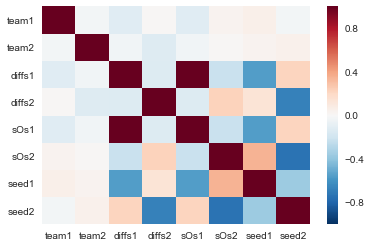

In [18]:
corr_grid = X_train.corr()
sns.heatmap(corr_grid)

#### The heatmap indicates correlation between a team's average margin of victory/loss and such team's seed.  I expected this correlation. It is the reason I have not included other team level data such as a team's won-loss record, because such data would likely be similarly correlated. 

## Modelling

The Kaggle competition requires the entrant to provide probability of wins rather than simply a binary classification.
I would prefer to use a classifier model that can easily provide such probabilities.  I chose LogisticRegression, RandomForestClassifier, and KNeighborsClassifier because each is different than the others. After reviewing the accuracy of each of these methods I 

I am using StandardScaler because the range for each of the three team level factors is different than the others.  I concerned about using StandardScaler on the seed -- because the seed is such an artificial construct, but Standard Scaler helped my model.

In [19]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)

Create a Logistic Regression Model using CV to optimize value of C

In [76]:
lrCV = LogisticRegressionCV(Cs=np.logspace(-4, 4, 10), cv=5, n_jobs=-1, solver='liblinear', random_state = 420)
lrCV.fit(X_train, y_train)
print('LogisticRegressionCV accuracy on training data is ', lrCV.score(X_train, y_train))
print('LogisticRegressionCV accuracy on test data is ', lrCV.score(X_test, y_test))

LogisticRegressionCV accuracy on training data is  0.925149700599
LogisticRegressionCV accuracy on test data is  0.921524663677


This logistic regression model performed almost as well on test data as it did on training data so I am optimistic, but will try other models. 

In [77]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print('RandomForestClassifer accuracy with default parameters on train data is ', clf.score(X_train, y_train))
print('RandomForestClassifer accuracy with default parameters on test data is ', clf.score(X_test, y_test))

RandomForestClassifer accuracy with default parameters on train data is  0.99251497006
RandomForestClassifer accuracy with default parameters on test data is  0.908071748879


RandomForestClassifer Model with default parameters is overfit, so will try to optimizer paramaters

In [79]:
clf_parameters = {
    'n_estimators': [5, 10, 15],
    'criterion': ['gini','entropy']
}
clf_gridsearch = GridSearchCV(RandomForestClassifier(), clf_parameters, n_jobs=-1)
clf_gridsearch.fit(X_train, y_train)
print('RandomForestClassifer accuracy with optimized parameters on training data is ', clf_gridsearch.score(X_test, y_test))
print('RandomForestClassifer accuracy with optimized parameters on test data is ', clf_gridsearch.score(X_test, y_test))

RandomForestClassifer accuracy with optimized parameters on training data is  0.908071748879
RandomForestClassifer accuracy with optimized parameters on test data is  0.908071748879


Random Forest Classifier Appears inferior to Logistic Regression, so try KNeighbors Classifier, Tune and Evaluate

In [80]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('KNN with default parameters on train data score: ', cross_val_score(knn, X_train, y_train).mean())
print('KNN with default parameters on tests data score: ', cross_val_score(knn, X_test, y_test).mean())

KNN with default parameters on train data score:  0.896709830201
KNN with default parameters on tests data score:  0.878922546708


In [81]:
knn_parameters = {
    'n_neighbors': [1,3,5,7,9],
    'weights': ['uniform','distance'],
    'metric': ['euclidean','manhattan']
}

knn_gridsearch = GridSearchCV(KNeighborsClassifier(), knn_parameters, n_jobs=-1)
knn_gridsearch.fit(X_train, y_train)
print('KNN Score with optimized parameters on traning data is ', cross_val_score(knn_gridsearch, X_train, y_train).mean())
print('KNN Score with optimized parameters on test data is ', cross_val_score(knn_gridsearch, X_test, y_test).mean())

KNN Score with optimized parameters on traning data is  0.904193748845
KNN Score with optimized parameters on test data is  0.876700526029


Evaluate Logistic Regression Model with a Confusion Matrix and ROC Curve. Both look encouraging, but the difference between false negatives and false positives is irrelevant in this context. A better evaluation is to use predictions on NCAA tournaments after 2012.

In [86]:
yhat = lrCV.predict(X_test)
conmat = np.array(confusion_matrix(y_test, yhat, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['team 1 won', 'team 2 won'],
                         columns=['predicted team 1','predicted team 2'])
confusion

,predicted team 1,predicted team 2
team 1 won,208,7
team 2 won,28,203


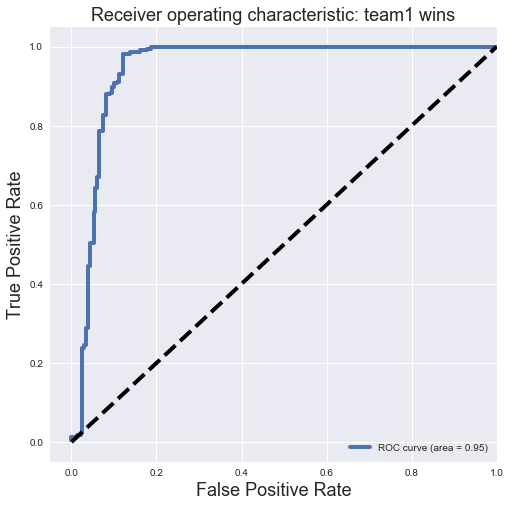

In [85]:
from sklearn.metrics import roc_curve, auc
yhat = lrCV.predict(X_test)
yhat_pp = lrCV.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test, yhat_pp[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: team1 wins', fontsize=18)
plt.legend(loc="lower right")
plt.show()

The shape of the ROC curve is encouraging, but the difference between false positives and false negatives is irrelevant in this context.

#### Test Data on NCAA Tournaments 2013-2016

In [101]:
dframe = pd.concat([dframe, ncaa2013], axis=0)

In [102]:
dframe.shape

(1849, 9)

In [96]:
ncaa2013 = make_dataset(2013)
dframe = pd.concat([dframe, ncaa2013], axis=0)
target = 'team1_wins'
y = dframe[target]
X = dframe[[col for col in dframe.columns if col != target]]
X = ss.fit_transform(X)

print('Accuracy for 2013 is ',  lrCV.score(X, y))

Accuracy for 2013 is  0.920314253648


In [103]:
ncaa2014 = make_dataset(2014)
dframe = pd.concat([dframe, ncaa2014], axis=0)
target = 'team1_wins'
y = dframe[target]
X = dframe[[col for col in dframe.columns if col != target]]
X = ss.fit_transform(X)

print('Accuracy for 2014 is ',  lrCV.score(X, y))

Accuracy for 2014 is  0.918580375783


In [104]:
ncaa2015 = make_dataset(2015)
dframe = pd.concat([dframe, ncaa2015], axis=0)
target = 'team1_wins'
y = dframe[target]
X = dframe[[col for col in dframe.columns if col != target]]
X = ss.fit_transform(X)

print('Accuracy for 2015 is ',  lrCV.score(X, y))

Accuracy for 2015 is  0.917801311145


In [105]:
ncaa2016 = make_dataset(2016)
dframe = pd.concat([dframe, ncaa2016], axis=0)
target = 'team1_wins'
y = dframe[target]
X = dframe[[col for col in dframe.columns if col != target]]
X = ss.fit_transform(X)

print('Accuracy for 2016 is ',  lrCV.score(X, y))

Accuracy for 2016 is  0.915609756098


## My model appears to perform pretty well, so here are next steps:

###### I will evaluate the model on the 2017 data that is not in the data set.
###### I will use a function to check the kaggle scoring on years 2013-2017.
###### I will use additional methods to tune the model.
###### I will fit the model on all data from 1985-2017.
###### I will consider engineering additional functions or using additional data -- questioning my assumptions.
##### I will use a function to prepare a submission in Kaggle's format for 2018.
